In [19]:
#Заданние 1
import numpy as np
import matplotlib.pyplot as plt
import itertools


def generator(shape, mtype=None, eps=1e-12):
    
    M = np.random.random(shape)
    
    if mtype is None:
        return M
    elif mtype == "triu":
        return np.triu(M)
    elif mtype == "tril":
        return np.tril(M) 
    elif mtype == "symmetric":
        if shape[0]==shape[1]:
            return (M+M.T)/2
        else:
            raise ValueError("Incorrect dimensions")
            
    elif mtype == "diag":
        if shape[0]==shape[1]:
            v = np.random.random(shape[0])
            return np.diag(v)
        else:
            raise ValueError("Incorrect dimensions")
    elif mtype == "singular":
        if shape[0]==shape[1]:
            v = np.random.random(shape[0])
            return v.T @ v
        else:
            raise ValueError("Incorrect dimensions")
            
    elif mtype == "step":
        m, n = shape 
        if m <= n:
            A = np.random.random((n, n))
            return np.triu(A, k=n-m)
        else:
            raise ValueError("m should be less or equal to n")
            
    elif mtype == "pert":
        return eps*np.random.random(shape)

In [4]:
generator((3,3), "diag")

array([[0.97825283, 0.        , 0.        ],
       [0.        , 0.93905143, 0.        ],
       [0.        , 0.        , 0.38240321]])

In [ ]:
#Задане 2

$||x||_2 \le ||x||_1 \le \sqrt{n}||x||_2$


$||x||^2_1 = \sum_i |x_i|^2 + \sum_{i\neq j} |x_i||x_j| \ge \sum_i |x_i|^2 =||x||_2 $

Неравенство о средних: $\frac{\sum |x_i|}{n} \le \sqrt{\frac{\sum |x_i|^2}{n}} \Leftrightarrow ||x||_1 \le \sqrt{n} ||x||_2$


In [ ]:
#Задание 3

$||x||_2 = \sqrt{\sum_{i=1}^m |x_i|^2} \le \sqrt{\sum_{i=1}^m (\max_{1 \le i\le m}|x_i|)^2} = \sqrt{\sum_{i=1}^m ||x||^2_\infty} = \sqrt{m}||x||_\infty$


$||A||_\infty  =\text{sup} \frac{||Ax||_\infty}{||x||_\infty} \leq \text{sup} \frac{||Ax||_2}{||x||_2/\sqrt{n}} = \sqrt{n}||A||_2$

Также мы знаем, что $||x||_\infty \leq \|x\|_2 \leq \sqrt{n}\|x\|_{\infty}$

In [ ]:
#Задание 4

$||A||_F = \sqrt{trace(AA^\dagger)} = \sqrt{trace(AUU^\dagger A^\dagger)} = \sqrt{trace(AU (AU)^\dagger)} = ||AU||_F$

$||A||_F = \sqrt{trace(A^\dagger A)} = \sqrt{trace(A^\dagger U^\dagger U A)} = \sqrt{trace((UA)^\dagger UA)} = ||UA||_F$

In [24]:
#Задание 5
c = 5

In [25]:
np.random.seed(42)
lambda1 = np.random.normal(size=(c, c))
lambda2 = np.random.normal(size=(c, c))
lambda3 = np.random.normal(size=(c, c))
G1 = np.random.normal(size=(c, c, c))
G2 = np.random.normal(size=(c, c, c))
U = np.random.normal(size=(c, c, c, c))

In [26]:
def Z_naive(lambda1, lambda2, lambda3, G1, G2, U):
    c = lambda1.shape[0]
    Z = np.zeros(shape=(c, c, c, c))
    for a, b, c, d, e, f, g, h, i, j in itertools.product(*([range(c)]*10)):
        Z[a, h, i, j] += lambda1[a, b]*lambda2[d, e]*lambda3[g, h]*G1[c, b, d]*G2[f, e, g]*U[i, j, c, f]
    return Z

def Z(lambda1, lambda2, lambda3, G1, G2, U):
    return np.einsum("ab,cbd,de,feg,gh,ijcf->ahij", lambda1, G1, lambda2, G2, lambda3, U, optimize=True)

In [27]:
%timeit -n 10 -r 2 Z(lambda1, lambda2, lambda3, G1, G2, U)

792 µs ± 277 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)


In [28]:
print(Z_naive(lambda1, lambda2, lambda3, G1, G2, U).shape)
print(Z(lambda1, lambda2, lambda3, G1, G2, U).shape)

(5, 5, 5, 5)
(5, 5, 5, 5)


In [29]:
print((np.sum(Z(lambda1, lambda2, lambda3, G1, G2, U) - Z_naive(lambda1, lambda2, lambda3, G1, G2, U))**2))

3.4267349894976454e-24


In [30]:
print(*np.einsum_path("ab,cbd,de,feg,gh,ijcf->ahij", lambda1, G1, lambda2, G2, lambda3, U, optimize=True))

['einsum_path', (0, 1), (0, 1), (0, 3), (1, 2), (0, 1)]   Complete contraction:  ab,cbd,de,feg,gh,ijcf->ahij
         Naive scaling:  10
     Optimized scaling:  6
      Naive FLOP count:  5.859e+07
  Optimized FLOP count:  4.125e+04
   Theoretical speedup:  1420.420
  Largest intermediate:  6.250e+02 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   4                 cbd,ab->acd                 de,feg,gh,ijcf,acd->ahij
   4                 feg,de->dfg                    gh,ijcf,acd,dfg->ahij
   4                 dfg,gh->dfh                       ijcf,acd,dfh->ahij
   5               dfh,acd->acfh                          ijcf,acfh->ahij
   6             acfh,ijcf->ahij                               ahij->ahij


Наивный способ

Для $Z_{ahij}=\underset{bcdefg}{\sum}\lambda^{(1)}_{ab}\Gamma^{(1)}_{cbd}\lambda^{(2)}_{de}\Gamma^{(2)}_{feg}\lambda^{(3)}_{gh}U_{ijcf}$ с размерностью индексов $\chi$ есть 6 индексов суммирования, т.е. $Z_{ahij}$ вычисляется за $\chi ^ 6$, весь тензор за $\chi ^ 6 \cdot\chi ^ 4$

Оптимизированный способ

Делаются свёртки 

- $\lambda^{(1)}_{ab}\Gamma^{(1)}_{cbd} = A_{acd}$ за $\chi$, т.е. $A$ за $\chi^4$


- $\lambda^{(2)}_{de}\Gamma^{(2)}_{feg} = B_{dfg}$, за $\chi$, т.е. $B$ за $\chi^4$

На этом моменте у нас есть два новых тензора $A, B$, которые мы вычислили за $2 \chi^4$

- $B_{dfg}\lambda^{(3)}_{gh}=C_{dfh}$ за $\chi$, т.е. $C$ за $\chi^4$

Добавляется ещё один тензор $C$, который мы вычислили за $\chi^4$, так как тензоры $B, \lambda^{(3)}$ были уже известны. На данный момент $3 \chi^4$ операций


- $C_{dfh}A_{acd}=D_{acfh}$ за $\chi$, т.е. $D$ за $\chi^3$

Новый тензор $D$, суммарно $3 \chi^4 + \chi^5$ операций


- $D_{acfh}U_{ijcf} = Z_{ahij}$ за $\chi^{2}$, т.е. ещё $\chi^{6}$ операций

В итоге вычислили тензор $Z$ за $O(\chi^{6})$ операций, наивный способ совершает $O(\chi^{10})$ операций. Оптимизация сложности происходит за счёт дополнительного расхода памяти, упрощения выражения, поэтому для небольшого числа операций лучше использовать обычное суммирование.

Для $\chi = 1$ получается (x0.02)


naive:  3.59 µs ± 220 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

optimised: 225 µs ± 3.51 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Для $\chi = 4$ получается (x4000)


naive: 1.59 s ± 25.5 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)

optimised: 401 µs ± 17.5 µs per loop (mean ± std. dev. of 2 runs, 100 loops each)

Для $\chi=50$: 

optimised: 438 ms ± 17 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)

Для $\chi=5-50$ naive заexplorить, к сожалению, не получается 

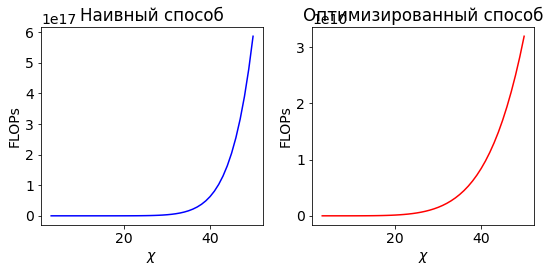

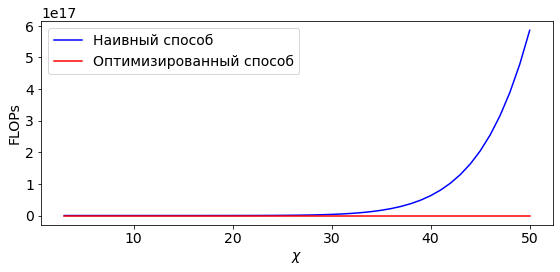

In [32]:
N, O = [], []
C = np.arange(3, 51)

for c in C:
    np.random.seed(42)
    lambda1 = np.random.normal(size=(c, c))
    lambda2 = np.random.normal(size=(c, c))
    lambda3 = np.random.normal(size=(c, c))
    G1 = np.random.normal(size=(c, c, c))
    G2 = np.random.normal(size=(c, c, c))
    U = np.random.normal(size=(c, c, c, c))
    
    res = np.einsum_path("ab,cbd,de,feg,gh,ijcf->ahij", lambda1, G1, lambda2, G2, lambda3, U, optimize=True)
    n, o = res[1].split('\n')[3:5]
    n = np.float64(n.split(' ')[-1])
    o = np.float64(o.split(' ')[-1])
    N.append(n)
    O.append(o)

    
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.plot(C, N, color="blue")
plt.title("Наивный способ")
plt.xlabel("$\chi$")
plt.ylabel("FLOPs")

plt.subplot(122)
plt.plot(C, O, color="red")
plt.title("Оптимизированный способ")
plt.xlabel("$\chi$")
plt.ylabel("FLOPs")

plt.tight_layout()

plt.figure(figsize=(8,4))
plt.plot(C, N, color="blue", label="Наивный способ")
plt.plot(C, O, color="red", label="Оптимизированный способ")
plt.xlabel("$\chi$")
plt.ylabel("FLOPs")

plt.legend()

plt.tight_layout()

In [34]:
c=3
np.random.seed(42)
lambda1 = np.random.normal(size=(c, c))
lambda2 = np.random.normal(size=(c, c))
lambda3 = np.random.normal(size=(c, c))
G1 = np.random.normal(size=(c, c, c))
G2 = np.random.normal(size=(c, c, c))
U = np.random.normal(size=(c, c, c, c))

In [35]:
lambda1
G1

array([[[ 0.37569802, -0.60063869, -0.29169375],
        [-0.60170661,  1.85227818, -0.01349722],
        [-1.05771093,  0.82254491, -1.22084365]],

       [[ 0.2088636 , -1.95967012, -1.32818605],
        [ 0.19686124,  0.73846658,  0.17136828],
        [-0.11564828, -0.3011037 , -1.47852199]],

       [[-0.71984421, -0.46063877,  1.05712223],
        [ 0.34361829, -1.76304016,  0.32408397],
        [-0.38508228, -0.676922  ,  0.61167629]]])

In [36]:
def mY_Z(lambda1, lambda2, lambda3, G1, G2, U):
    c=2
    A = np.tensordot(lambda1,G1, axes=([1], [1]))
    B = np.tensordot(lambda2, G2, axes=([1],[1]))
    C = np.tensordot(B, lambda3, axes=([2], [0]))
    D = np.tensordot(A, C, axes=([2], [0]))
    Z = np.tensordot(D, U, axes=([1, 2], [2,3]))
    
    return Z

In [37]:
assert np.allclose(mY_Z(lambda1, lambda2, lambda3, G1, G2, U), Z(lambda1, lambda2, lambda3, G1, G2, U))

In [39]:
O, my, Oerr, myerr = [], [], [], []
C = np.arange(3, 51)

for c in C:
    np.random.seed(42)
    lambda1 = np.random.normal(size=(c, c))
    lambda2 = np.random.normal(size=(c, c))
    lambda3 = np.random.normal(size=(c, c))
    G1 = np.random.normal(size=(c, c, c))
    G2 = np.random.normal(size=(c, c, c))
    U = np.random.normal(size=(c, c, c, c))
    

    time1 = %timeit -o -q -n 2 -r 2 mY_Z(lambda1, lambda2, lambda3, G1, G2, U)
    time2 = %timeit -o -q -n 2 -r 2 Z(lambda1, lambda2, lambda3, G1, G2, U)
    
    my.append(time1.average)
    myerr.append(3*time1.stdev)
    O.append(3*time2.average)
    Oerr.append(time2.stdev)

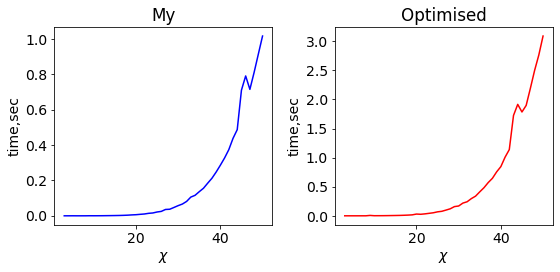

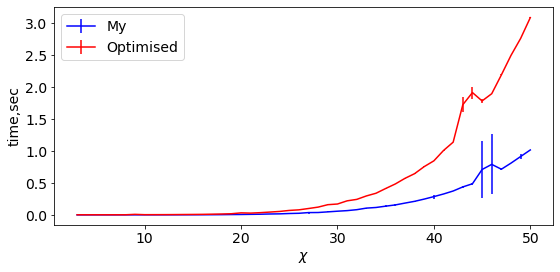

In [41]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.plot(C, my, color="blue")
plt.title("My")
plt.xlabel("$\chi$")
plt.ylabel("time,sec")

plt.subplot(122)
plt.plot(C, O, color="red")
plt.title("Optimised")
plt.xlabel("$\chi$")
plt.ylabel("time,sec")

plt.tight_layout()

plt.figure(figsize=(8,4))
plt.errorbar(C, my, myerr, color="blue", label="My")
plt.errorbar(C, O, Oerr, color="red", label="Optimised")
plt.xlabel("$\chi$")
plt.ylabel("time,sec")

plt.legend()

plt.tight_layout()

In [50]:
#Задание 6
N = 1000
K = 3
d = 3
L = 10

np.random.seed(42)
mu_true = np.random.uniform(-L, L, size = (K, d))
data = np.random.normal(mu_true, size = (N, K, d))
data = np.vstack(data)
np.random.shuffle(data)

In [47]:
def scatter_plot(data, col=None):
    from mpl_toolkits.mplot3d import Axes3D 
    %matplotlib inline
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], s = 0.5, color=col)
    plt.show()

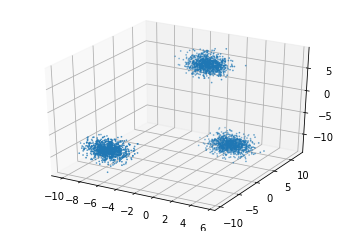

In [49]:
scatter_plot(data, None)

In [54]:
def naive_dist_i(x, mu):
    dist = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        dist[i] = np.sum((x[i] - mu[i])**2)
    return dist

def naive_dist_ij(x, mu):
    dist = np.zeros((x.shape[0], mu.shape[0]))
    for i in range(x.shape[0]):
        for j in range(mu.shape[0]):
            dist[i, j] += np.sum((x[i] - mu[j])**2)
    return dist

def naive_kmeans():
    ss_list=[]
    mu = data[np.random.choice(range(data.shape[0]), K, replace=False)]
    c = np.random.randint(low=0, high=K-1, size=data.shape[0])
    for n in range(10):
        c =  np.argmin(naive_dist_ij(data, mu), axis = 1)    
        ss = np.mean(naive_dist_i(data, mu[c]))
        ss_list.append(ss)    
        for i in range(K):
            cluster_members = data[c == i]
            cluster_members = cluster_members.mean(axis = 0)
            mu[i] = cluster_members
    return ss_list, c

In [55]:
def dist_i(x, mu):
    return np.sum((x - mu)**2)

def dist_ij(x, mu):
    n, k = x.shape
    x_mod = np.transpose(x[None,...].repeat(k, axis=0), axes=(1, 0, 2))
    mu_mod = mu[None, ...]
    return np.sum((x_mod-mu_mod)*(x_mod-mu_mod), axis=2)
   
def kmeans():
    ss_list=[]
    mu = data[np.random.choice(range(data.shape[0]), K, replace=False)]
    c = np.random.randint(low=0, high=K-1, size=data.shape[0])
    
    for _ in range(10):
        c =  np.argmin(dist_ij(data, mu), axis = 1)    
        ss = np.mean(dist_i(data, mu[c]))
        ss_list.append(ss)    
        for i in range(K):
            mu[i] = data[c==i].mean(axis=0)
    return ss_list, c

In [56]:
%timeit naive_kmeans()
%timeit kmeans()

1.08 s ± 340 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


9.59 ms ± 94.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


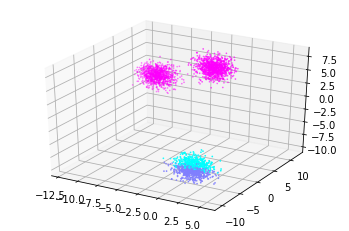

In [59]:
ss_list, c = kmeans()
plt.plot(ss_list)

colors = np.array([plt.cm.cool(i/(K-1)) for i in range(K)])
if d == 3:
    scatter_plot(data, colors[c])

Итог:

При N=1000 naive_kmeans работает за 874 ms ± 77.6 ms ms, kmeans за 7.7 ms ± 265 µs, т.е. быстрее примерно в 100 раз

naive_kmeans для N=10000 colab уже не обрабатывает